# SNAX package tutorial

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [2]:
# A.delete_object()

In [3]:
# A = sn.Models(model_name='Fornax_2021',index=5, storage="../../../scratch/SN_rewiev/", config_file="../simple_config.conf") #  
A = sn.Models(model_name='Fornax_2021', index=5)

> You chose ~wisely~ ->	   [5]	lum_spec_15M_r10000_dat.h5
> Retrieving object self.storage/15.0 solMass.pickle


In [4]:
A.compute_rates();

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [5]:
N_events = 1000
sampled_Er = A.sample_data(N_events)
sampled_t = A.sample_data(N_events, dtype='time')

These parts are better done in dali/midway. <br>


In [6]:
from multimessenger.supernova.Simulate import generator_sn_instruction
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [7]:
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

Caution, the times need to be passed in nanoseconds!

In [8]:
nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))
    
instr = generator_sn_instruction(energy_deposition=sampled_Er, timemode=sampled_t*1e9, n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [9]:
runid = "snsim_02"

In [10]:
import cutax, strax
st = cutax.contexts.xenonnt_sim_SR0v1_cmt_v8(cmt_run_id="026000")

/dali/lgrandi/xenonnt/software/cutax/latest/cutax/contexts.py:85: UserWarning: WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!
  warnings.warn("WARNING! You are using SR0 v1 simulation context! Consider updating to a newer version!")


In [11]:
# set s1 minimum coincidence to 0
st.set_config({"s1_min_coincidence":0})

In [12]:
# simulate with this context
st = A.simulate_one(df, runid, context=st)

snsim_02 is created! Returning context!


In [13]:
peak_basics = st.get_df(runid, "peak_basics")
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([2, 1, 0], dtype=int8), 9, 708, 975)

/tmp/jobs/21865626/ipykernel_145/3736824744.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"],
/tmp/jobs/21865626/ipykernel_145/3736824744.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"],
/tmp/jobs/21865626/ipykernel_145/3736824744.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"],


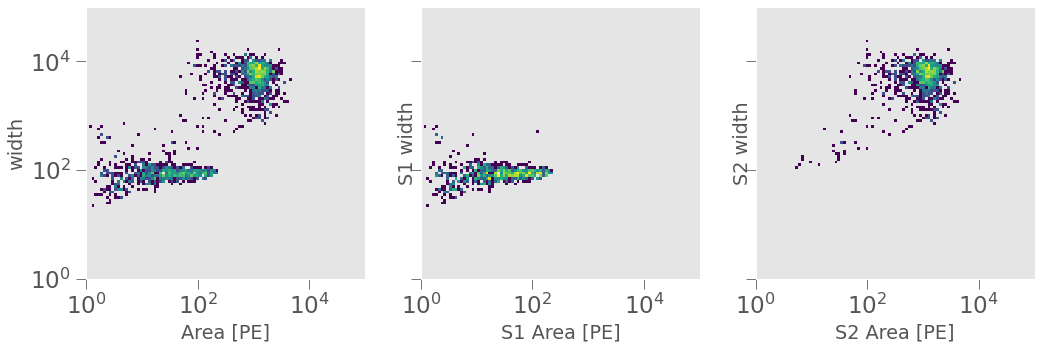

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

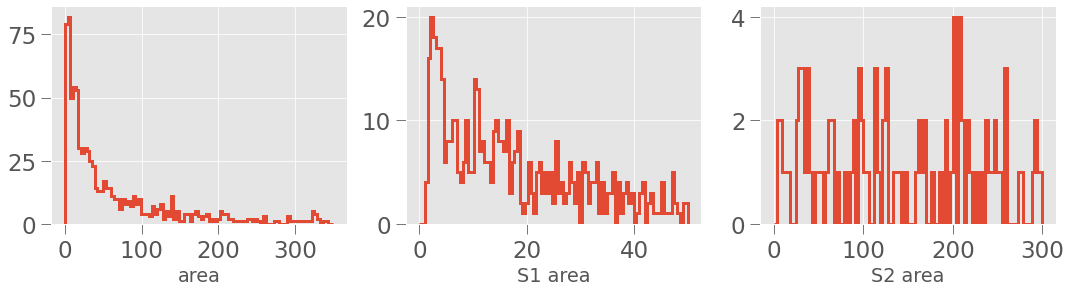

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,4))
ax0.hist(peak_basics['area'], bins=np.linspace(0, 350, 100), histtype='step', lw=3)
ax1.hist(peak_s1['area'], bins=np.linspace(0, 50, 100), histtype='step', lw=3)
ax2.hist(peak_s2['area'], bins=np.linspace(0,300,100), histtype='step', lw=3);
ax0.set_xlabel("area"); ax1.set_xlabel("S1 area"); ax2.set_xlabel("S2 area");

### Test the plugin

In [18]:
from numpy.lib.recfunctions import append_fields

export, __all__ = strax.exporter()

st8 = cutax.contexts.xenonnt_v8()

In [19]:
@export
@strax.takes_config(
    strax.Option('sn_time_bin', default=5, type=int,
                 help='Time range which you want to find the rate over [s]'),
    strax.Option('min_area_electrons', default=123/32, type=int,
                 help='Minumum number of electrons in primary S2 [electrons]'),
    strax.Option('max_area_electrons', default=350/32, type=int,
                 help='Maximum number of electrons in primary S2 [electrons]'),
    strax.Option('min_width_ns', default=300, type=int,
                 help='Minumum width of S2 [ns]'),
    strax.Option('min_primary_size_pe', default=1000, type=int,
                 help='Minumum size of primary S2 [PE]'),
    strax.Option('shadow_cut_threshold', default=0.04, type=np.float64,
                 help='Shadow cut value for delay time cuts after primary S2'),
    strax.Option('dt_cut_ns', default=4.4e6, type=np.float64,
                 help='Delay time cut value after primary S2'),
    strax.Option('dr_cut_cm', default=8.0, type=int,
                 help='Radius around primary S2 to exclude/cut away [cm]'),

)
class SNPugin(strax.Plugin):
    """
    This is a test plugin
    """
    __version__ = '0.1.22'
    
    depends_on = ('peak_basics','peak_positions')
    provides = ('sn_rate')
    dtype = [
            ('sn_rate', np.float64,'Rate of peaks for SN [Hz]'),
            ('sn_rate_err', np.float64,'Error on rate of peaks for SN [sqrt(Hz)]'),
            ('time', np.int64,'Start time of bin since unix epoch [ns]'),
            ('endtime', np.int64,'End time of bin since unix epoch [ns]')
            ]
        
    def compute(self, peaks):   
        
        peaks_dt_dr_cuts = primary_matching(peaks, 
                                            self.config['min_primary_size_pe'], 
                                            self.config['shadow_cut_threshold'], 
                                            self.config['dr_cut_cm'],
                                            self.config['dt_cut_ns']
                                           )
        
        
        rate, err, t_start, t_end = calculate_rate(peaks,#_dt_dr_cuts, 
                                                     self.config['sn_time_bin'], 
                                                     self.config['min_area_electrons'],
                                                     self.config['max_area_electrons'], 
                                                     self.config['min_width_ns']
                                                    )
        
        df = pd.DataFrame()
        df['time'] = t_start
        df['endtime'] = t_end
        df['sn_rate'] = rate
        df['sn_rate_err'] = err
        
        return df


def calculate_rate(peaks, time_bin_s, min_area_electrons, max_area_electrons, min_width_ns):
    se_gain = 32
    min_area_pe = se_gain*min_area_electrons
    max_area_pe = se_gain*max_area_electrons
    
    peaks_cut = peaks[#(peaks['area'] > min_area_pe) 
                    #& (peaks['area'] < max_area_pe)
                    #& (peaks['range_50p_area'] > min_width_ns)
                    #& 
                    (peaks['type']==2)]
    
    if len(peaks_cut) == 0:
        #'Do nothing'
        pass
        

    else:
        t_ns = peaks_cut['time'][0]

        time_s_to_ns = 1e9
        time_bin_ns = time_bin_s*time_s_to_ns

        rates = []
        rates_err = []
        t_start = []
        t_end = []

        while t_ns+time_bin_ns < peaks['time'][-1]:
            df_here = peaks_cut[(peaks_cut['time'] >= t_ns) & (peaks_cut['time'] < t_ns+time_bin_ns)]
            s2s = len(df_here)
            s2s_err = np.sqrt(s2s)
            rate = s2s/time_bin_s
            rate_err = s2s_err/time_bin_s

            rates.append(rate)
            rates_err.append(rate_err)
            t_start.append(t_ns)
            t_end.append(t_ns+time_bin_ns)

            if t_ns + time_bin_ns >= peaks['time'][-1]:
                t_ns = t_ns
            else:
                t_ns += time_bin_ns

        ## last bin when we are less than 5s from the end
        df_here = peaks_cut[(peaks_cut['time'] >= t_ns) & (peaks_cut['time'] <= peaks['time'][-1])]
        dt = (peaks['time'][-1] - t_ns)/1e9


        s2s = len(df_here)
        s2s_err = np.sqrt(s2s)
        rate = s2s/dt
        rate_err = s2s_err/dt

        rates.append(rate)
        rates_err.append(rate_err)
        t_start.append(t_ns)
        t_end.append(peaks['time'][-1])
    
    return rates, rates_err, t_start, t_end


def primary_matching(df, min_primary_size, shadow_cut_threshold, dr_cut_cm, dt_cut_ns):
    max_drift_ns = 2.5e6
        
    #primary definition
    primary = df[(df['area'] > min_primary_size) & (df['type'] == 2)]
    primary.sort(order='center_time')

    #small S2s
    S2s = df[ (df['type'] == 2) & (df['area'] > 10) & (df['area'] < min_primary_size)]
    S2s = S2s[S2s['center_time'] >= min(primary['center_time'])]
    S2s.sort(order='center_time')

    #pairing
    prim_i = np.digitize(S2s['center_time'],primary['center_time']) - [1]*len(S2s)
    area_primary = primary['area'][prim_i]
    dt_primary = S2s['center_time'] - primary['center_time'][prim_i] 
    x_diff = S2s['x_mlp'] - primary['x_mlp'][prim_i]
    y_diff = S2s['y_mlp'] - primary['y_mlp'][prim_i]
    
    r_diff = np.nan_to_num(np.sqrt(x_diff**2 + y_diff**2))
    shadow = area_primary/dt_primary
    S2s = append_fields(S2s, 'r_diff', r_diff)
    S2s = append_fields(S2s, 'shadow', shadow)
    S2s = append_fields(S2s, 'dt_primary', dt_primary)
    
    #shadow cut
    S2s_dtcut = S2s#[S2s['shadow'] > shadow_cut_threshold]
    
    #delay time cut
    S2s_dtcut = S2s[S2s['dt_primary'] > dt_cut_ns]
    
    #position correlation cut
    S2s_drcut = S2s_dtcut[S2s_dtcut['r_diff'] > dr_cut_cm]
    return S2s_drcut

In [24]:
st8.register(SNPugin)

st.register(SNPugin)

__main__.SNPugin

In [29]:
df_test = st.get_df([runid], 'sn_rate')

Loading sn_rate: |          | 0.00 % [00:00<?]

In [30]:
df_test

,sn_rate,sn_rate_err,time,endtime
0,256.568619,8.216772,25932090,3826085060


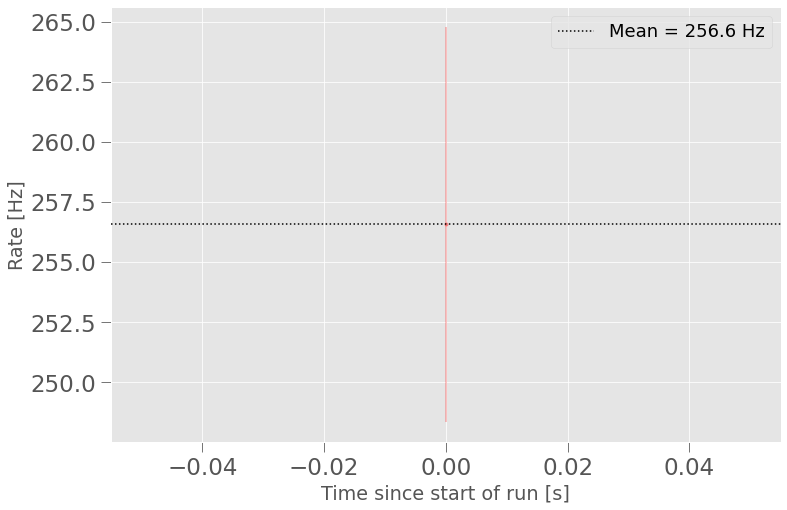

In [26]:
plt.figure(figsize=(12,8))
plt.errorbar(x=(df_test['time']-df_test['time'][0])/1e9, 
             y=df_test['sn_rate'],
             yerr=df_test['sn_rate_err'], 
             color='r', marker='.',linestyle='',alpha=0.3)
plt.axhline(np.mean(df_test['sn_rate']), color='k',linestyle=':', 
            zorder=10, label='Mean = %.1f Hz'%np.mean(df_test['sn_rate']))

plt.legend()
plt.xlabel('Time since start of run [s]')
plt.ylabel('Rate [Hz]')
plt.show()